In [1]:
# reloads modules automatically
%load_ext autoreload 

# reloads modules automatically
%autoreload 2

In [2]:
import io
from PIL import Image
import matplotlib.pyplot as plt

def display_image_from_bytes(image_bytes):
    # Create a BytesIO object
    image_stream = io.BytesIO(image_bytes)
    
    # Open the image using PIL
    image = Image.open(image_stream)
    
    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')  # Hide the axes
    plt.show()

In [3]:
import argparse
import sys

from dotenv import load_dotenv
load_dotenv(override=True)

sys.path.append("..")
import textgrad as tg
from load_task import load_multimodal_instance_task

def config():
    parser = argparse.ArgumentParser(description="Optimize the Chameleon system for the ScienceQA task.")
    parser.add_argument("--task", type=str, default="scienceqa", help="The task to evaluate the model on.")   
    parser.add_argument("--multimodal", action='store_true', help="Determine if we want to load multimodal dataset.")
    parser.add_argument("--task_instruction", type=str, default=None, help="The instruction for the task.")
    parser.add_argument("--evaluation_instruction", type=str, default=None, help="The instruction for the evaluation.")
    parser.add_argument("--instance_role", type=str, default=None, help="The role description of the instance.")
    parser.add_argument("--image_role", type=str, default=None, help="The role description of the image.")
    parser.add_argument("--question_role", type=str, default=None, help="The role description of the question.")
    parser.add_argument("--engine", type=str, default="gpt-4o", help="The API to use for inference.")
    parser.add_argument("--eval_engine", type=str, default="gpt-4o", help="The API to use for evaluation.")
    parser.add_argument("--test_num", type=int, default=-1, help="The number of test samples to evaluate., -1 means all.")
    
    # Parse known args first
    args, unknown = parser.parse_known_args()
    
    # If there are unknown arguments, print a warning
    if unknown:
        print(f"Warning: Unknown arguments {unknown}")
    
    return args

In [4]:
args = config()

In [5]:
llm_engine = tg.get_engine(engine_name=args.engine, check_cache=False)
tg.set_backward_engine(llm_engine, override=True)

eval_engine = tg.get_engine(engine_name=args.eval_engine, check_cache=False)
test_set = load_multimodal_instance_task(args.task,
                                        evaluation_api=eval_engine, 
                                        task_instruction=args.task_instruction, # NOTE: check the instruction
                                        evaluation_instruction=args.evaluation_instruction, # NOTE: check the instruction
                                        )

total = min(args.test_num, len(test_set)) if args.test_num > 0 else len(test_set)

Loaded ScienceQA dataset from cache.


## The Example Question from ScienceQA

In [6]:
image_bytes, query, answer, ques_data, *_ = test_set[46]
pid = ques_data["pid"]

In [7]:
print(ques_data)

{'pid': '46', 'question': 'Think about the magnetic force between the magnets in each pair. Which of the following statements is true?', 'answer': 1, 'choices': ['The magnetic force is stronger in Pair 1.', 'The magnetic force is stronger in Pair 2.', 'The strength of the magnetic force is the same in both pairs.'], 'hint': 'The images below show two pairs of magnets. The magnets in different pairs do not affect each other. All the magnets shown are made of the same material.', 'has_image': True, 'task': 'closed choice', 'grade': 'grade3', 'subject': 'natural science', 'topic': 'physics', 'category': 'Magnets', 'skill': 'Compare strengths of magnetic forces'}


In [8]:
print(query)

You will answer a scientific question based on an image. Please ensure you accurately interpret the image and think step by step. The last line of your answer should be formatted as follows: 'Answer: (X) Your Option.'
Context: The images below show two pairs of magnets. The magnets in different pairs do not affect each other. All the magnets shown are made of the same material.
Question: Think about the magnetic force between the magnets in each pair. Which of the following statements is true?
Choices: (A) The magnetic force is stronger in Pair 1. (B) The magnetic force is stronger in Pair 2. (C) The strength of the magnetic force is the same in both pairs.


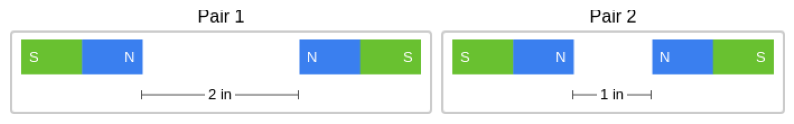

In [9]:
display_image_from_bytes(image_bytes)

## Forward Pass to Get the Initial Solution

In [10]:
from chameleon_modules import ChameleonAgent

In [11]:
agent = ChameleonAgent(args)
output = agent(pid=pid, example=ques_data, image_bytes=image_bytes) # run the agent

Loading cache from ocr_cache.json

==> [Predicted Modules]: ['text_detector', 'knowledge_retrieval', 'solution_generator', 'answer_generator']

==> [Module at 0]: text_detector

==> [Remaining modules at 0]: ['knowledge_retrieval', 'solution_generator', 'answer_generator']

==> [Variable to optimize at 0]: Detected text in the image: [[[[165, 0], [211, 0], [211, 15], [165, 15]], 'Pair 1'], [[[515, 0], [561, 0], [561, 15], [515, 15]], 'Pair 2']]

==> [Module at 1]: knowledge_retrieval

==> [Remaining modules at 1]: ['solution_generator', 'answer_generator']

==> [Variable to optimize at 1]: 

Knowledge:
- Magnets exert forces on each other, which can be either attractive or repulsive, depending on their orientation.
- The strength of the magnetic force between two magnets is influenced by several factors, including the distance between the magnets and their alignment.
- The closer the magnets are to each other, the stronger the magnetic force between them. Conversely, as the distance in

In [12]:
initial_solution = agent.state["solution"].value
print(f"# [Initial Solution]: {initial_solution}\n")

initial_prediction = output.value
print(f"# [Initial Prediction]: {initial_prediction}\n")

# [Initial Solution]: 

Solution: To determine which statement about the magnetic force between the magnets in each pair is true, we need to consider the factors that influence magnetic force:

1. **Distance Between Magnets**: The magnetic force is stronger when magnets are closer together. If one pair of magnets is closer than the other, the force in that pair will be stronger.

2. **Orientation of Magnets**: The orientation (whether the poles are aligned to attract or repel) can affect the force, but since the question does not specify different orientations, we assume they are similar.

3. **Material of Magnets**: All magnets are made of the same material, so this factor is constant and does not affect the comparison.

4. **Size and Shape of Magnets**: These can affect the magnetic field distribution, but again, without specific differences mentioned, we assume they are similar.

Given that the primary factor we can assess is the distance between the magnets, we need to compare the 

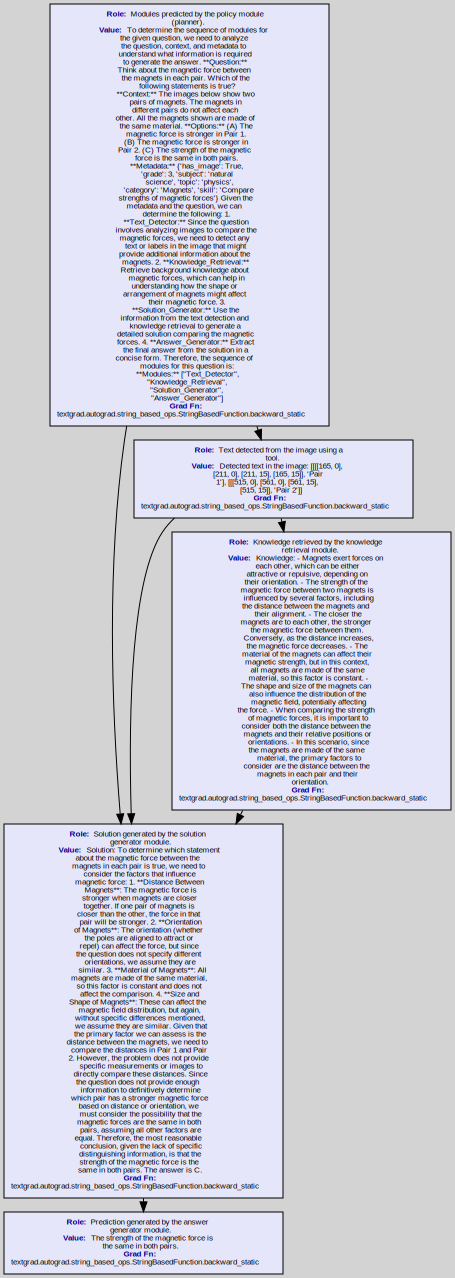

In [13]:
output.generate_graph()

## TextGrad Optimization for the Example Question

In [14]:
from textgrad.loss import ImageQALoss

evaluation_instruction = "Please analyze whether the generated solution is accurate and informative for answering the question. If it is not, provide feedback to refine the solution, ensuring it is relevant and helpful. The final solution should be concise and informative, providing a clear answer or explanation to help answer the question effectively."
loss_fn = ImageQALoss(evaluation_instruction=evaluation_instruction, engine=args.eval_engine)

image_variable = tg.Variable(image_bytes, role_description="image to answer a question about", requires_grad=False)

query_role = "The task involves generating a solution to the question based on the context, metadata, and knowledge provided. The prompt asks to provide a solution that can help answer the question effectively, considering the question content, image, and background information. The solution may include steps, explanations, or answers related to the question, helping to enhance the answer quality."
query_variable = tg.Variable(query, role_description=query_role, requires_grad=False)

loss_fn_instance = lambda solution: loss_fn(question=query_variable, image=image_variable, response=solution)

final_prediction = agent.optimize(loss_fn_instance)

print("\nDone!")



####################################################################################################
==> [Optimizing module 1]: knowledge_retrieval
####################################################################################################

==> [Variable to optimize at 1 (Output before optimization)]:


Knowledge:
- Magnets exert forces on each other, which can be either attractive or repulsive, depending on their orientation.
- The strength of the magnetic force between two magnets is influenced by several factors, including the distance between the magnets and their alignment.
- The closer the magnets are to each other, the stronger the magnetic force between them. Conversely, as the distance increases, the magnetic force decreases.
- The material of the magnets can affect their magnetic strength, but in this context, all magnets are made of the same material, so this factor is constant.
- The shape and size of the magnets can also influence the distribution of the magneti

In [15]:
agent.state

{'solution': Variable(value=
 
 Solution: To determine which statement about the magnetic force between two pairs of magnets is correct, we need to consider the inverse square law. This law states that the magnetic force is inversely proportional to the square of the distance between the magnets. 
 
 1. **Understanding the Inverse Square Law**: The magnetic force between two magnets decreases rapidly as the distance between them increases. Conversely, the force increases as the distance decreases.
 
 2. **Comparison of Distances**: 
    - In Pair 1, the magnets are separated by a 2-inch gap.
    - In Pair 2, the gap is only 1 inch.
 
 3. **Application of the Inverse Square Law**: Since the magnetic force is stronger when the distance is shorter, Pair 2, with a 1-inch gap, will have a stronger magnetic force compared to Pair 1, which has a 2-inch gap.
 
 Therefore, the magnetic force is stronger in Pair 2 due to the shorter distance between the magnets.
 
 The answer is B., role=solutio

## The Refined Solution from TextGrad

In [16]:
# final solution
final_solution = agent.state["optimized_solution"].value
print(f"==> [Final Solution]\n{final_solution}\n")

==> [Final Solution]


Solution: To determine which statement about the magnetic force between two pairs of magnets is correct, we need to consider the inverse square law. This law states that the magnetic force is inversely proportional to the square of the distance between the magnets. 

1. **Understanding the Inverse Square Law**: The magnetic force between two magnets decreases rapidly as the distance between them increases. Conversely, the force increases as the distance decreases.

2. **Comparison of Distances**: 
   - In Pair 1, the magnets are separated by a 2-inch gap.
   - In Pair 2, the gap is only 1 inch.

3. **Application of the Inverse Square Law**: Since the magnetic force is stronger when the distance is shorter, Pair 2, with a 1-inch gap, will have a stronger magnetic force compared to Pair 1, which has a 2-inch gap.

Therefore, the magnetic force is stronger in Pair 2 due to the shorter distance between the magnets.

The answer is B.



In [17]:
# final prediction
print(f"==> [Final Prediction]\n{final_prediction}\n")

==> [Final Prediction]
The magnetic force is stronger in Pair 2.

